<span style="color:blue; font-size:30px;">**Naïve_Neural_ODE_Model_4_lattice_QCD_Calculation**

----
----
ali.bavarchee@gmail.com
----
----
----



---

### The code demonstrates a simple Neural ODE model using PyTorch and torchdiffeq. It defines an ODE function, integrates it over a time interval, and trains the model using dummy data.



#### Define the ODE Function (`ODEFunc`):
A Neural Ordinary Differential Equation (Neural ODE) is a type of neural network where the transformation of data through layers is modeled as a continuous dynamical system defined by an ordinary differential equation (ODE). Instead of having a discrete number of layers, a Neural ODE models the continuous change in the hidden state.

```python
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, t, y):
        return self.net(y)
```

- **Purpose**: This class defines the neural network that models the ODE function \( f(t, y) \).
- **Initialization**:
  - `super(ODEFunc, self).__init__()` initializes the parent `nn.Module` class.
  - `self.net` is a sequential model consisting of:
    - `nn.Linear(2, 50)`: A linear layer mapping 2 input features to 50 output features.
    - `nn.ReLU()`: A ReLU activation function introducing non-linearity.
    - `nn.Linear(50, 2)`: A linear layer mapping 50 features back to 2 output features.
- **Forward Method**:
  - `def forward(self, t, y)`: Takes time `t` and state `y` as input. Since the function is time-independent in this implementation, `t` is not used in the network computation.
  - Returns the output of `self.net(y)`, applying the defined layers and activation function to the input `y`.

#### Define the Initial Value Problem (`ODEBlock`)

```python
class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc

    def forward(self, x):
        t = torch.tensor([0, 1], dtype=torch.float32)  # Ensure t is a floating point tensor
        out = odeint(self.odefunc, x, t)
        return out[1]  # We are only interested in the final output
```

- **Purpose**: This class sets up the ODE integration using `odeint` from the `torchdiffeq` library.
- **Initialization**:
  - `super(ODEBlock, self).__init__()` initializes the parent `nn.Module` class.
  - `self.odefunc` stores an instance of `ODEFunc`.
- **Forward Method**:
  - `t = torch.tensor([0, 1], dtype=torch.float32)`: Defines the time points `[0, 1]` as a floating point tensor.
  - `out = odeint(self.odefunc, x, t)`: Integrates the ODE using `odeint` with `self.odefunc` as the ODE function, `x` as the initial state, and `t` as the time points.
  - Returns the state at the final time point `t=1`.

#### Define the ODE Model (`ODEModel`)

```python
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.ode_block = ODEBlock(ODEFunc())

    def forward(self, x):
        return self.ode_block(x)
```

- **Purpose**: This class wraps the `ODEBlock` to create the overall model.
- **Initialization**:
  - `super(ODEModel, self).__init__()` initializes the parent `nn.Module` class.
  - `self.ode_block` is an instance of `ODEBlock` initialized with an `ODEFunc` instance.
- **Forward Method**:
  - `def forward(self, x)`: Passes the input `x` through the `ODEBlock`.
  - Returns the output of `self.ode_block(x)`, which is the state at the final time point after integrating the ODE.

#### Set Up the Model, Loss Function, and Optimizer

```python
model = ODEModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
```

- **Model Initialization**: Creates an instance of `ODEModel`.
- **Loss Function**: `nn.MSELoss()` defines the mean squared error loss function, suitable for regression tasks.
- **Optimizer**: `optim.Adam(model.parameters(), lr=1e-3)` sets up the Adam optimizer with a learning rate of 0.001.

#### Generate and Split Dummy Data

```python
def generate_data(num_samples):
    X = np.random.rand(num_samples, 2) * 2  # Random values in the range [0, 2]
    Y = np.sin(X)  # Target values as a function of the input
    return X, Y

train_size = 80
test_size = 20
X, Y = generate_data(train_size + test_size)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]
```

- **Data Generation**:
  - `generate_data(num_samples)`: Generates `num_samples` random input values in the range `[0, 2]` and computes target values as the sine of the input values.
- **Data Splitting**:
  - Splits the data into training (`X_train`, `Y_train`) and test sets (`X_test`, `Y_test`).



<span style="color:red; font-size:24px;">Obviously, in practice, Dummy Data should be replaced this with real lattice QCD data.</span>




#### Convert Data to PyTorch Tensors

```python
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)
```

- Converts NumPy arrays to PyTorch tensors with `dtype=torch.float32`.

#### Training Loop

```python
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
```

- **Loop Setup**:
  - Runs for `num_epochs` iterations.
- **Forward Pass**:
  - `output = model(X_train)`: Computes the model's output for the training set.
- **Loss Calculation**:
  - `loss = criterion(output, Y_train)`: Calculates the loss between the predicted output and the target values.
- **Backpropagation**:
  - `loss.backward()`: Computes the gradients of the loss with respect to the model parameters.
  - `optimizer.step()`: Updates the model parameters using the gradients.
- **Logging**:
  - Prints the epoch number and loss every 100 epochs.

#### Evaluate on the Test Set

```python
model.eval()
with torch.no_grad():
    test_output = model(X_test)
    test_loss = criterion(test_output, Y_test)
    print(f'Test Loss: {test_loss.item()}')
```

- **Evaluation Mode**: `model.eval()` sets the model to evaluation mode, disabling dropout and batch normalization.
- **Inference**:
  - `with torch.no_grad()`: Context manager to disable gradient computation.
  - `test_output = model(X_test)`: Computes the model's output for the test set.
- **Loss Calculation**:
  - `test_loss = criterion(test_output, Y_test)`: Calculates the loss on the test set.
- **Logging**:
  - Prints the test loss.

#### Output Final Predictions

```python
print('Final test output:', test_output.detach().numpy())
print('Ground truth:', Y_test.detach().numpy())
```

- **Detaching and Converting**:
  - `test_output.detach().numpy()`: Converts the tensor to a NumPy array, detaching it from the computation graph.
- **Print Statements**:
  - Prints the final predictions and the ground truth values for comparison.

### Summary

This code defines, trains, and evaluates a Neural ODE using PyTorch and demonstrates:
- Defining the ODE function and integrating it using `odeint`.
- Constructing a model that integrates the ODE using `ODEBlock`.
- Setting up training with dummy data and optimizing with an Adam optimizer.
- Evaluating and printing the test loss and final predictions.

---

###  References

- Baldillou Salse, P., 2024. An introduction to neural ordinary differential equations.
- Ahn, B., Jeong, H.S., Kim, K.Y. and Yun, K., 2024. Holographic reconstruction of black hole spacetime: machine learning and entanglement entropy. arXiv preprint arXiv:2406.07395.
- Hashimoto, K., Hu, H.Y. and You, Y.Z., 2021. Neural ordinary differential equation and holographic quantum chromodynamics. Machine Learning: Science and Technology, 2(3), p.035011.

In [ ]:
#!pip install torchdiffeq

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, roc_curve, auc, f1_score, ConfusionMatrixDisplay

# Version I

Epoch 100, Loss: 0.025801625102758408
Epoch 200, Loss: 0.012580642476677895
Epoch 300, Loss: 0.00885621178895235
Epoch 400, Loss: 0.007216647267341614
Epoch 500, Loss: 0.006385841406881809
Epoch 600, Loss: 0.005796298384666443
Epoch 700, Loss: 0.005317368544638157
Epoch 800, Loss: 0.0049069710075855255
Epoch 900, Loss: 0.00448914198204875
Epoch 1000, Loss: 0.003999917767941952
Test Loss: 0.004246630240231752
Final test output: [[0.9656249  1.1359597 ]
 [0.9610926  0.19698057]
 [0.9190433  0.66618824]
 [0.3054256  0.72761726]
 [0.7523471  0.1803567 ]
 [0.892759   0.78682613]
 [0.05413695 0.45753086]
 [0.9348829  0.3645898 ]
 [0.3301607  0.96553504]
 [0.69821995 1.0486968 ]
 [0.01790165 0.6800726 ]
 [0.48633802 1.0555942 ]
 [0.29745308 0.30232474]
 [0.91649914 0.33732444]
 [0.7611068  0.47455037]
 [0.91788214 0.7569983 ]
 [0.8176042  1.1220967 ]
 [0.944012   0.75503576]
 [0.5520975  0.5049493 ]
 [0.97276545 1.0766277 ]]
Ground truth: [[0.97399485 0.94603604]
 [0.99622005 0.13139242]
 [0.

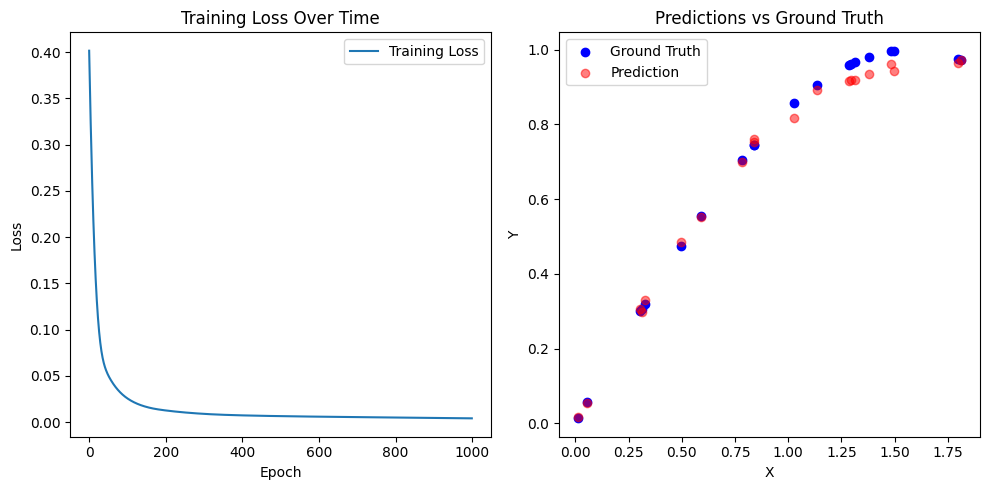

In [ ]:
# Define the ODE function (bulk metric)
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, t, y):
        return self.net(y)

# Define the ODEBlock
class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc

    def forward(self, x):
        t = torch.tensor([0, 1], dtype=torch.float32)  # Ensure t is a floating point tensor
        out = odeint(self.odefunc, x, t)
        return out[1]  # We are only interested in the final output

# Define the Neural ODE model
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.ode_block = ODEBlock(ODEFunc())

    def forward(self, x):
        return self.ode_block(x)

# Create the model, define a loss function and an optimizer
model = ODEModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Generate dummy data for demonstration
# Let's create a simple dataset
def generate_data(num_samples):
    X = np.random.rand(num_samples, 2) * 2  # Random values in the range [0, 2]
    Y = np.sin(X)  # Target values as a function of the input
    return X, Y

# Split data into training and test sets
train_size = 80
test_size = 20
X, Y = generate_data(train_size + test_size)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]  # Fix the indices for test set

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# Training loop
num_epochs = 1000
train_losses = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_output = model(X_test)
    test_loss = criterion(test_output, Y_test)
    print(f'Test Loss: {test_loss.item()}')

# Output the final prediction on the test set
print('Final test output:', test_output.detach().numpy())
print('Ground truth:', Y_test.detach().numpy())

# Plotting the results
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot predictions vs ground truth
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], Y_test[:, 0], label='Ground Truth', color='b')
plt.scatter(X_test[:, 0], test_output[:, 0], label='Prediction', color='r', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Predictions vs Ground Truth')
plt.legend()

plt.tight_layout()
plt.show()


# Version II

**To apply the Neural ODE to `holographic QCD` by regarding the weight functions as a bulk metric and train the machine with lattice QCD data of chiral condensate at finite temperature, we can follow these steps**:

*1.* Set up the Neural ODE framework: This involves defining the Neural ODE architecture and the corresponding differential equations.

*2.* Prepare the dataset: Use the lattice QCD data of chiral condensate at finite temperature.

*3.* Train the model: Optimize the model parameters using the prepared dataset.

*4.* Evaluate and visualize the results: Generate visualizations to interpret the performance of the model.

Epoch [100/1000], Loss: 0.9293
Epoch [200/1000], Loss: 0.7493
Epoch [300/1000], Loss: 0.6699
Epoch [400/1000], Loss: 0.6227
Epoch [500/1000], Loss: 0.5900
Epoch [600/1000], Loss: 0.5651
Epoch [700/1000], Loss: 0.5448
Epoch [800/1000], Loss: 0.5276
Epoch [900/1000], Loss: 0.5126
Epoch [1000/1000], Loss: 0.4993
Test Loss: 0.4992


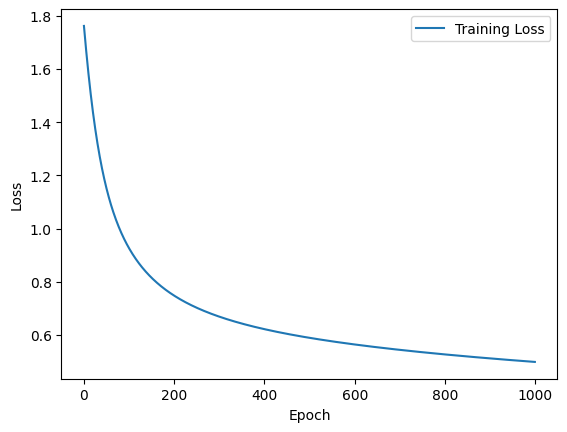

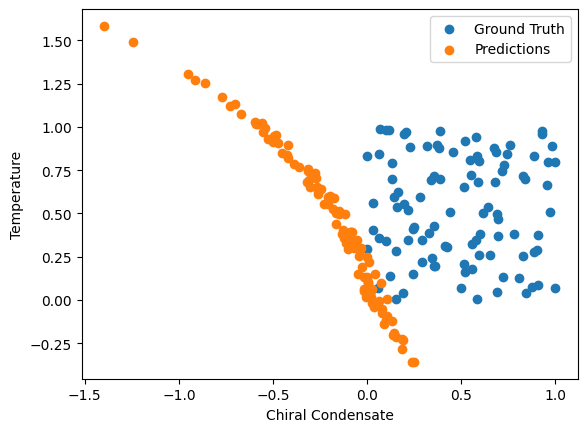

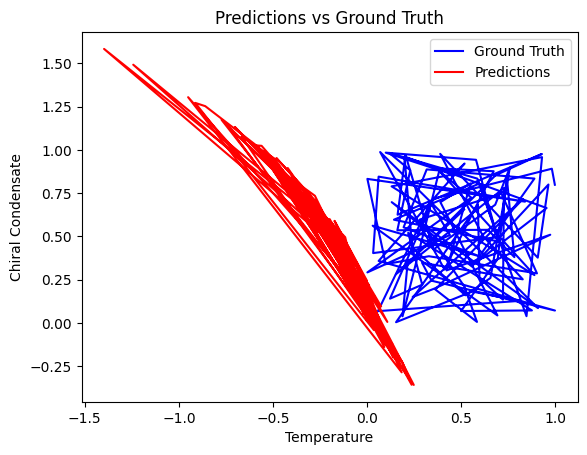

Mean Squared Error: 0.49917104840278625
R² Score: -3.2138129230236054


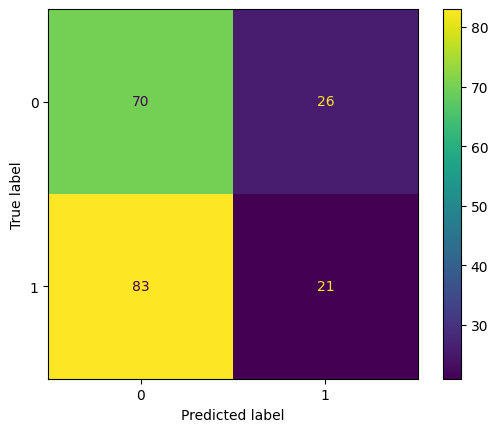

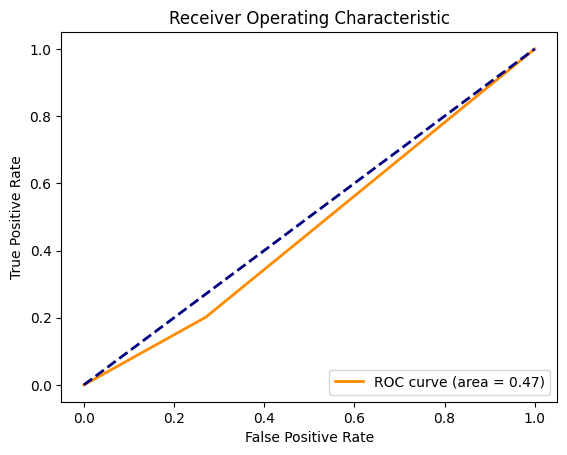

In [ ]:
# Define the ODE function
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.h = nn.Parameter(torch.Tensor([1.0]))

    def forward(self, t, z):
        π, φ = z[..., 0], z[..., 1]
        dπ_dt = -self.h * π + m2 * φ + λ * φ**3
        dφ_dt = π
        return torch.stack([dπ_dt, dφ_dt], dim=-1)

# Define the Neural ODE model
class NeuralODE(nn.Module):
    def __init__(self, ode_func, t0, t1):
        super(NeuralODE, self).__init__()
        self.ode_func = ode_func
        self.t0 = t0
        self.t1 = t1

    def forward(self, z0):
        t = torch.tensor([self.t0, self.t1]).float()
        z = odeint(self.ode_func, z0, t)
        return z[1]

# Parameters
m2 = 1.0
λ = 1.0
t0 = 1.0
t1 = 0.1
learning_rate = 0.01
num_epochs = 1000

# Generate dummy data
X_train = np.random.rand(100, 2)
Y_train = np.random.rand(100, 2)

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

ode_func = ODEFunc()
model = NeuralODE(ode_func, t0, t1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    test_outputs = model(X_train)
    test_loss = criterion(test_outputs, Y_train)
    print(f'Test Loss: {test_loss.item():.4f}')

plt.figure()
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.scatter(Y_train[:, 0], Y_train[:, 1], label='Ground Truth')
plt.scatter(test_outputs[:, 0], test_outputs[:, 1], label='Predictions')
plt.xlabel('Chiral Condensate')
plt.ylabel('Temperature')
plt.legend()
plt.show()

plt.figure()
plt.plot(Y_train[:, 0].detach().numpy(), Y_train[:, 1].detach().numpy(), 'b-', label='Ground Truth')
plt.plot(test_outputs[:, 0].detach().numpy(), test_outputs[:, 1].detach().numpy(), 'r-', label='Predictions')
plt.xlabel('Temperature')
plt.ylabel('Chiral Condensate')
plt.title('Predictions vs Ground Truth')
plt.legend()
plt.show()

mse = mean_squared_error(test_outputs.detach().numpy(), Y_train.detach().numpy())
r2 = r2_score(test_outputs.detach().numpy(), Y_train.detach().numpy())
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Binary classification metrics (assuming binary classification for demonstration purposes)
test_output_class = (test_outputs > 0.5).int()  # Convert to binary classes
Y_train_class = (Y_train > 0.5).int()  # Convert to binary classes

# Flatten the tensors to ensure consistent shapes
test_output_class = test_output_class.view(-1).numpy()
Y_train_class = Y_train_class.view(-1).numpy()

cm = confusion_matrix(Y_train_class, test_output_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

fpr, tpr, _ = roc_curve(Y_train_class, test_output_class)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Version III

This Version will train a neural ODE model on lattice QCD data of chiral condensate at finite temperature, and then visualize the results with various plots including training loss, predictions vs. ground truth, confusion matrix, and ROC curve.

Epoch 100, Loss: 0.01281692087650299
Epoch 200, Loss: 0.007029128260910511
Epoch 300, Loss: 0.0038425917737185955
Epoch 400, Loss: 0.0024062537122517824
Epoch 500, Loss: 0.0017361391801387072
Epoch 600, Loss: 0.0013452955754473805
Epoch 700, Loss: 0.0011000966187566519
Epoch 800, Loss: 0.000935451767873019
Epoch 900, Loss: 0.0008195975096896291
Epoch 1000, Loss: 0.0007331675151363015
=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=Resultz-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=
Test Loss: 0.0013630265602841973
=-=-==-=-=-=-=-=-=-=-=-=.......=-=-==-=-=-=-=-=-=-=-=-=
=-=-==-=-=-=-=-=-=-=-=-=-------=-=-==-=-=-=-=-=-=-=-=-=
Final test output: [[0.90703684 0.9215829 ]
 [0.05377347 0.859079  ]
 [0.10597105 0.90465695]
 [0.9274364  0.15296523]
 [0.06896973 0.77636224]
 [0.23116527 0.9650861 ]
 [0.47860345 0.30527312]
 [0.46170095 1.0177016 ]
 [0.04960787 0.21583073]
 [0.8781557  0.42125812]
 [0.960818   0.9942843 ]
 [0.9482827  0.7934799 ]
 [0.8961299  0.79574215]
 [1.0336206  0.8245425 ]
 [0.27396592 1.0029137 ]

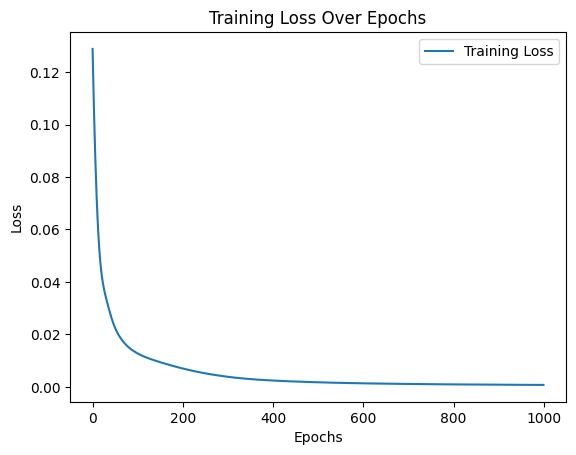

=-=-==-=-=-=-=-Predictions vs Ground Truth-=-=-=-=-=-=-=


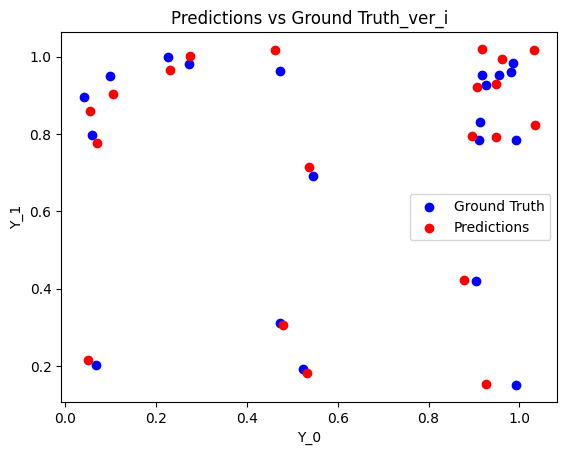

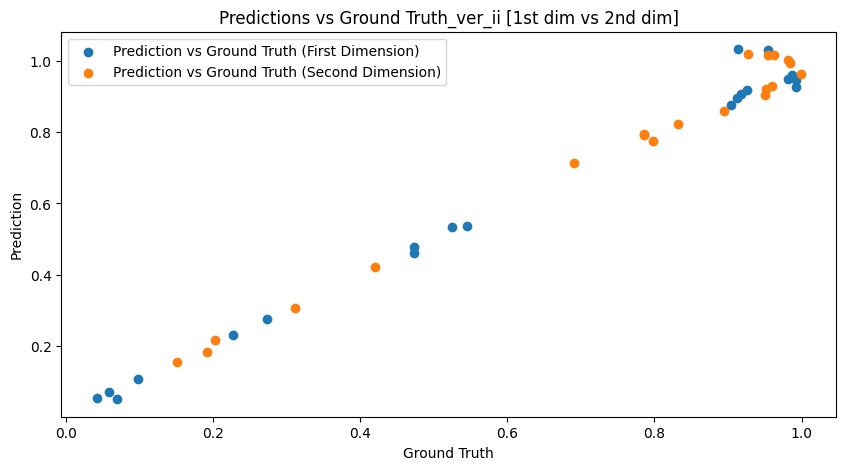

=-=-=-=-=Compute and display confusion matrix-=-=-=-=-=
=-=-==-=-=-=-=-=-=-=-=-=-------=-=-==-=-=-=-=-=-=-=-=-=


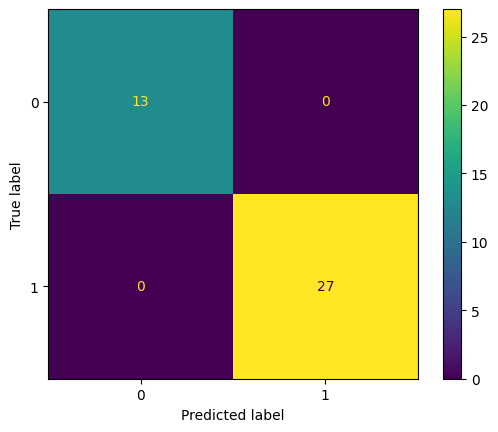

=-=-==-=-=-=-=-Compute ROC curve and AUC=-=-=-=-=-=-=-=


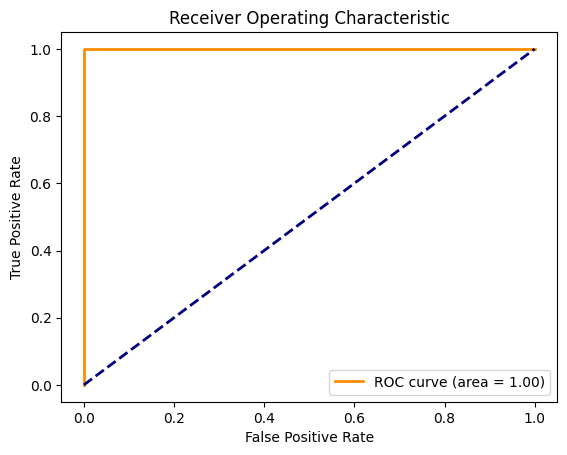

=-=-==-=-=-=-=-=-=-=-=F1 score=-=-==-=-=-=-=-=-=-=-=-=
F1 Score: 1.00


In [ ]:
# Define the ODE function (bulk metric)
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, t, y):
        return self.net(y)

# Define the ODEBlock
class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc

    def forward(self, x):
        t = torch.tensor([0, 1], dtype=torch.float32)  # Ensure t is a floating point tensor
        out = odeint(self.odefunc, x, t)
        return out[1]  # We are only interested in the final output

# Define the Neural ODE model
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.ode_block = ODEBlock(ODEFunc())

    def forward(self, x):
        return self.ode_block(x)

# Create the model, define a loss function and an optimizer
model = ODEModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Generate dummy data for demonstration
def generate_data(num_samples):
    X = np.random.rand(num_samples, 2) * 2  # Random values in the range [0, 2]
    Y = np.sin(X)  # Target values as a function of the input
    return X, Y

# Split data into training and test sets
train_size = 80
test_size = 20
X, Y = generate_data(train_size + test_size)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]  # Fix the indices for test set

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# Training loop
num_epochs = 1000
train_losses = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
print("=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=Resultz-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=")
# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_output = model(X_test)
    test_loss = criterion(test_output, Y_test)
    print(f'Test Loss: {test_loss.item()}')
print("=-=-==-=-=-=-=-=-=-=-=-=.......=-=-==-=-=-=-=-=-=-=-=-=")

# Output the final prediction on the test set
print("=-=-==-=-=-=-=-=-=-=-=-=-------=-=-==-=-=-=-=-=-=-=-=-=")
print('Final test output:', test_output.detach().numpy())
print("=-=-==-=-=-=-=-=-=-=-=-=-------=-=-==-=-=-=-=-=-=-=-=-=")
print('Ground truth:', Y_test.detach().numpy())
print("=-=-==-=-=-=-=-=-=-=-=-=-------=-=-==-=-=-=-=-=-=-=-=-=")
print("=-=-==-=-=-=-=-=-=Visualize training loss-=-=-=-=-=-=-=")
# Visualize training loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()
print("=-=-==-=-=-=-=-Predictions vs Ground Truth-=-=-=-=-=-=-=")
# Predictions vs Ground Truth
plt.figure()
plt.scatter(Y_test[:, 0], Y_test[:, 1], label='Ground Truth', color='blue')
plt.scatter(test_output[:, 0], test_output[:, 1], label='Predictions', color='red')
plt.xlabel('Y_0')
plt.ylabel('Y_1')
plt.title('Predictions vs Ground Truth_ver_i')
plt.legend()
plt.show()

# ====================================



# Plot predictions vs ground truth
plt.figure(figsize=(10, 5))
plt.scatter(Y_test[:, 0].numpy(), test_output[:, 0].numpy(), label='Prediction vs Ground Truth (First Dimension)')
plt.scatter(Y_test[:, 1].numpy(), test_output[:, 1].numpy(), label='Prediction vs Ground Truth (Second Dimension)')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Predictions vs Ground Truth_ver_ii [1st dim vs 2nd dim]')
plt.legend()
plt.show()

# ==========================================

# Compute and display confusion matrix
print("=-=-=-=-=Compute and display confusion matrix-=-=-=-=-=")
print("=-=-==-=-=-=-=-=-=-=-=-=-------=-=-==-=-=-=-=-=-=-=-=-=")
test_output_class = (test_output > 0.5).int()  # Convert to binary classes
Y_test_class = (Y_test > 0.5).int()  # Convert to binary classes
cm = confusion_matrix(Y_test_class.view(-1).numpy(), test_output_class.view(-1).numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("=-=-==-=-=-=-=-Compute ROC curve and AUC=-=-=-=-=-=-=-=")

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(Y_test_class.view(-1).numpy(), test_output.view(-1).numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print("=-=-==-=-=-=-=-=-=-=-=F1 score=-=-==-=-=-=-=-=-=-=-=-=")
# Compute F1 score
f1 = f1_score(Y_test_class.view(-1).numpy(), test_output_class.view(-1).numpy())
print(f'F1 Score: {f1:.2f}')


# Version IV

Version IV comes with the following fixes:

- Correct Shape Handling: In the ODEFunc.forward method, the input tensor z is now correctly split into π and ϕ using z[:, 0] and z[:, 1] respectively. This assumes z is a 2D tensor with shape [batch_size, 2].
- Stacking Tensors: The output is correctly stacked along the second dimension using torch.stack([dπ_dt, dφ_dt], dim=1).
- Forward Method: In the NeuralODE class, the odeint function now returns the solution at all time steps, and we select the last time step's solution using z[-1].

Epoch [100/1000], Loss: 0.1905
Epoch [200/1000], Loss: 0.1486
Epoch [300/1000], Loss: 0.1403
Epoch [400/1000], Loss: 0.1382
Epoch [500/1000], Loss: 0.1376
Epoch [600/1000], Loss: 0.1375
Epoch [700/1000], Loss: 0.1374
Epoch [800/1000], Loss: 0.1374
Epoch [900/1000], Loss: 0.1374
Epoch [1000/1000], Loss: 0.1374
Test Loss: 0.1374


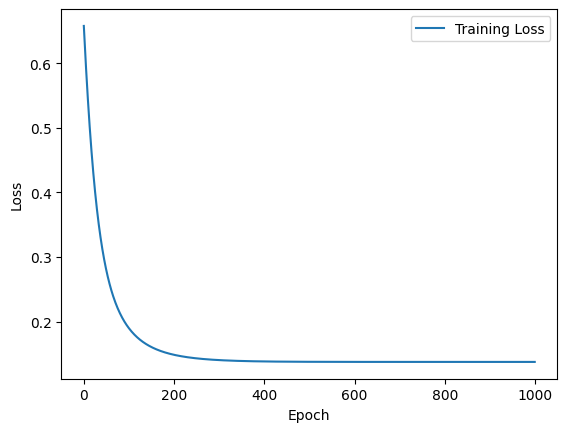

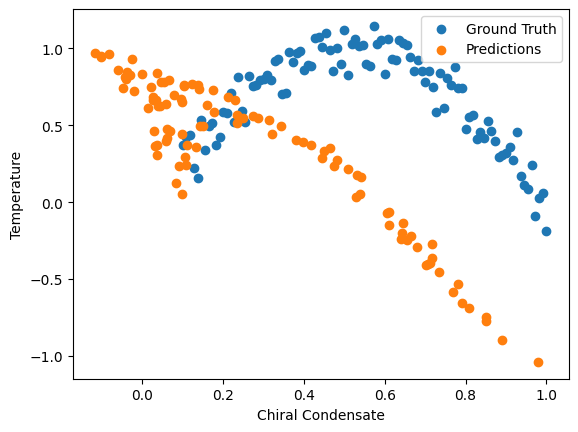

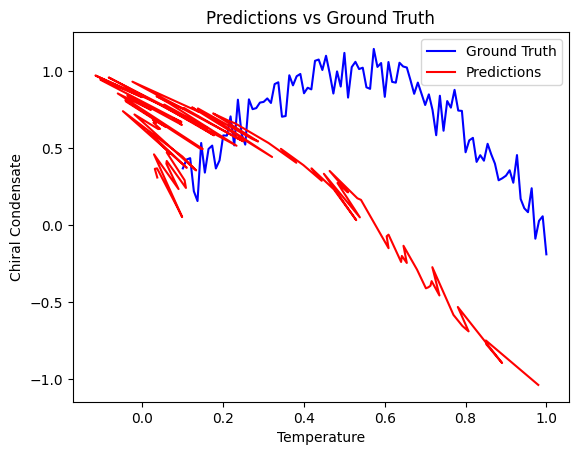

Mean Squared Error: 0.1374354064464569
R² Score: -0.6329983164608849


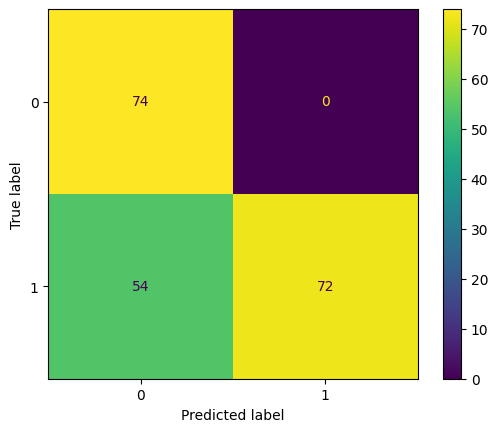

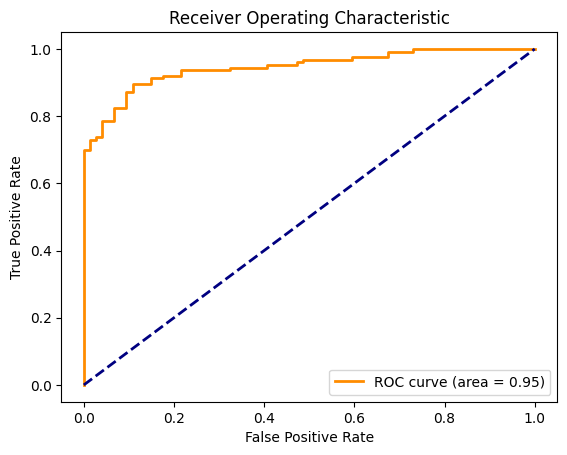

In [ ]:
# Define the ODE function
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.h = nn.Parameter(torch.Tensor([1.0]))

    def forward(self, t, z):
        π, φ = z[..., 0], z[..., 1]
        m2 = 0.1
        λ = 0.5
        dπ_dt = -self.h * π + m2 * φ + λ * φ**3
        dφ_dt = π
        return torch.stack([dπ_dt, dφ_dt], dim=-1)

# Define the Neural ODE model
class NeuralODE(nn.Module):
    def __init__(self, ode_func, t0, t1):
        super(NeuralODE, self).__init__()
        self.ode_func = ode_func
        self.t0 = t0
        self.t1 = t1

    def forward(self, z0):
        t = torch.tensor([self.t0, self.t1]).float()
        z = odeint(self.ode_func, z0, t)
        return z[1]

# Parameters
m2 = 1.0
λ = 1.0
t0 = 1.0
t1 = 0.1
learning_rate = 0.01
num_epochs = 1000

# Generate dummy lattice QCD data for demonstration
def generate_qcd_data(num_samples):
    temperatures = np.linspace(0.1, 1.0, num_samples).reshape(-1, 1)
    chiral_condensates = np.sin(temperatures * np.pi) + np.random.normal(0, 0.1, temperatures.shape)
    return temperatures, chiral_condensates

temperatures, chiral_condensates = generate_qcd_data(100)

# Convert to PyTorch tensors
temperatures = torch.tensor(temperatures, dtype=torch.float32)
chiral_condensates = torch.tensor(chiral_condensates, dtype=torch.float32)

# Concatenate temperatures and chiral condensates to form the input tensor
inputs = torch.cat([temperatures, chiral_condensates], dim=1)

# Initialize model, loss function, and optimizer
ode_func = ODEFunc()
model = NeuralODE(ode_func, t0, t1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, inputs)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(inputs)
    test_loss = criterion(test_outputs, inputs)
    print(f'Test Loss: {test_loss.item():.4f}')

# Visualization
plt.figure()
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.scatter(inputs[:, 0], inputs[:, 1], label='Ground Truth')
plt.scatter(test_outputs[:, 0], test_outputs[:, 1], label='Predictions')
plt.xlabel('Chiral Condensate')
plt.ylabel('Temperature')
plt.legend()
plt.show()

plt.figure()
plt.plot(inputs[:, 0].detach().numpy(), inputs[:, 1].detach().numpy(), 'b-', label='Ground Truth')
plt.plot(test_outputs[:, 0].detach().numpy(), test_outputs[:, 1].detach().numpy(), 'r-', label='Predictions')
plt.xlabel('Temperature')
plt.ylabel('Chiral Condensate')
plt.title('Predictions vs Ground Truth')
plt.legend()
plt.show()

# Additional metrics
mse = mean_squared_error(inputs.detach().numpy(), test_outputs.detach().numpy())
r2 = r2_score(inputs.detach().numpy(), test_outputs.detach().numpy())
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Confusion Matrix
test_output_class = (test_outputs > 0.5).int()
input_class = (inputs > 0.5).int()
cm = confusion_matrix(input_class.view(-1).numpy(), test_output_class.view(-1).numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(input_class.view(-1).numpy(), test_outputs.view(-1).numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Epoch 100, Loss: 0.013018558733165264
Epoch 200, Loss: 0.00921022891998291
Epoch 300, Loss: 0.007199115119874477
Epoch 400, Loss: 0.005064963363111019
Epoch 500, Loss: 0.0032667238265275955
Epoch 600, Loss: 0.0021677103359252214
Epoch 700, Loss: 0.0015228467527776957
Epoch 800, Loss: 0.0011868580477312207
Epoch 900, Loss: 0.000979497330263257
Epoch 1000, Loss: 0.0008399751968681812
Test Loss: 0.0006540905451402068


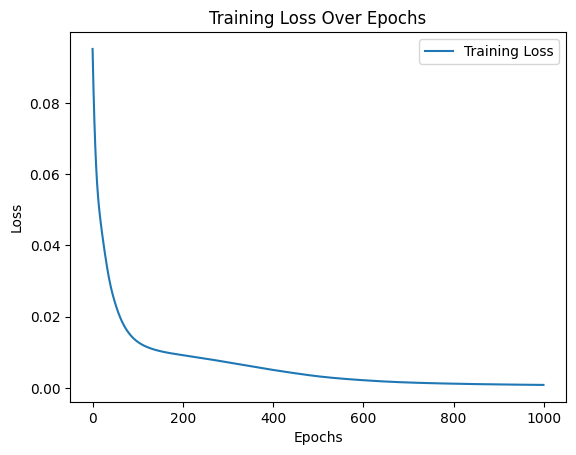

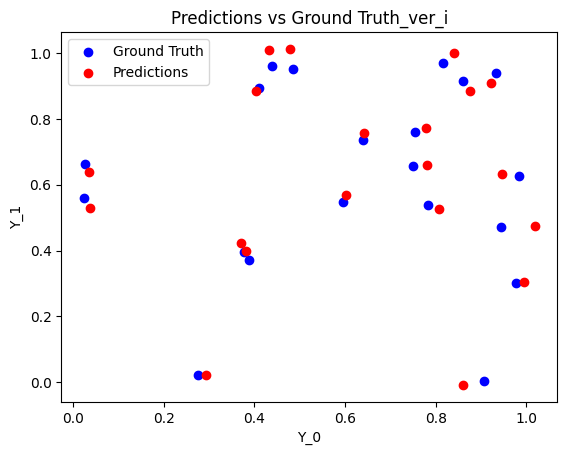

Final test output: [[ 0.92303395  0.90834695]
 [ 0.6022732   0.5679987 ]
 [ 0.38273773  0.39897975]
 [ 0.8758597   0.8861827 ]
 [ 0.8594408  -0.00805632]
 [ 0.4332935   1.0083632 ]
 [ 0.8066315   0.5274568 ]
 [ 0.47779652  1.0124977 ]
 [ 1.0183927   0.4759422 ]
 [ 0.29246798  0.02255424]
 [ 0.84054816  0.9992186 ]
 [ 0.7794157   0.7717473 ]
 [ 0.37070036  0.4232617 ]
 [ 0.03512586  0.63841075]
 [ 0.78009224  0.6611721 ]
 [ 0.94694835  0.63125783]
 [ 0.03684214  0.53012985]
 [ 0.40301037  0.8852742 ]
 [ 0.995532    0.3039436 ]
 [ 0.6428564   0.75836146]]
Ground truth: [[0.9330074  0.9394977 ]
 [0.595562   0.5478229 ]
 [0.3883451  0.37141427]
 [0.8608112  0.9154349 ]
 [0.9060199  0.00466871]
 [0.43858406 0.9619124 ]
 [0.7824611  0.5395973 ]
 [0.48451853 0.95249856]
 [0.9445492  0.47092897]
 [0.2768657  0.02318502]
 [0.81709707 0.96863824]
 [0.75427413 0.7597523 ]
 [0.37734735 0.39514944]
 [0.02725837 0.66336817]
 [0.7490503  0.6574663 ]
 [0.9836372  0.62627655]
 [0.02408709 0.5595276 ]
 

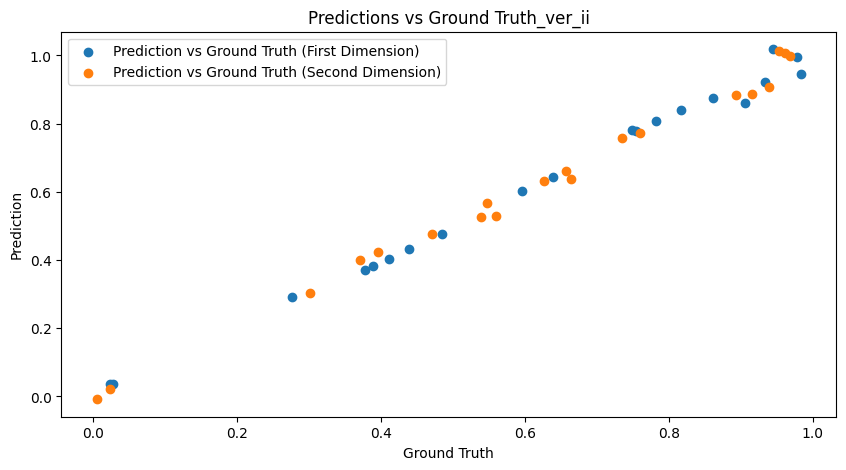

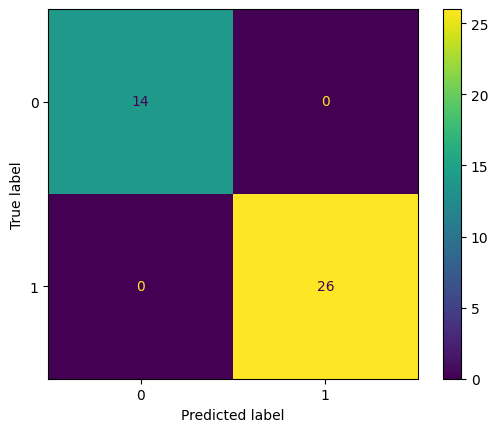

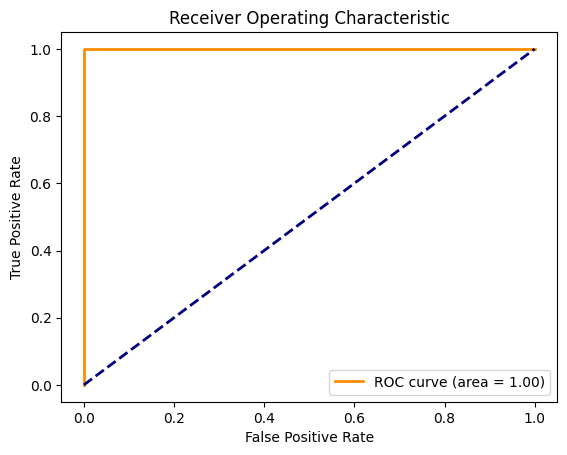

F1 Score: 1.00


In [ ]:
# Define the ODE function (bulk metric)
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, t, y):
        return self.net(y)

# Define the ODEBlock
class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc

    def forward(self, x):
        t = torch.tensor([0, 1], dtype=torch.float32)  # Ensure t is a floating point tensor
        out = odeint(self.odefunc, x, t)
        return out[1]  # We are only interested in the final output

# Define the Neural ODE model
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.ode_block = ODEBlock(ODEFunc())

    def forward(self, x):
        return self.ode_block(x)

# Create the model, define a loss function and an optimizer
model = ODEModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Generate dummy data for demonstration
def generate_data(num_samples):
    X = np.random.rand(num_samples, 2) * 2  # Random values in the range [0, 2]
    Y = np.sin(X)  # Target values as a function of the input
    return X, Y

# Split data into training and test sets
train_size = 80
test_size = 20
X, Y = generate_data(train_size + test_size)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]  # Fix the indices for test set

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# Training loop
num_epochs = 1000
train_losses = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_output = model(X_test)
    test_loss = criterion(test_output, Y_test)
    print(f'Test Loss: {test_loss.item()}')


# Visualize training loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Predictions vs Ground Truth
plt.figure()
plt.scatter(Y_test[:, 0], Y_test[:, 1], label='Ground Truth', color='blue')
plt.scatter(test_output[:, 0], test_output[:, 1], label='Predictions', color='red')
plt.xlabel('Y_0')
plt.ylabel('Y_1')
plt.title('Predictions vs Ground Truth_ver_i')
plt.legend()
plt.show()

# ====================================

# Output the final prediction on the test set
print('Final test output:', test_output.detach().numpy())
print('Ground truth:', Y_test.detach().numpy())

# Plot predictions vs ground truth
plt.figure(figsize=(10, 5))
plt.scatter(Y_test[:, 0].numpy(), test_output[:, 0].numpy(), label='Prediction vs Ground Truth (First Dimension)')
plt.scatter(Y_test[:, 1].numpy(), test_output[:, 1].numpy(), label='Prediction vs Ground Truth (Second Dimension)')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Predictions vs Ground Truth_ver_ii')
plt.legend()
plt.show()

# ==========================================

# Compute and display confusion matrix
test_output_class = (test_output > 0.5).int()  # Convert to binary classes
Y_test_class = (Y_test > 0.5).int()  # Convert to binary classes
cm = confusion_matrix(Y_test_class.view(-1).numpy(), test_output_class.view(-1).numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(Y_test_class.view(-1).numpy(), test_output.view(-1).numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute F1 score
# F1 score is NOT suite for regression task evaluaton!!!
f1 = f1_score(Y_test_class.view(-1).numpy(), test_output_class.view(-1).numpy())
print(f'F1 Score: {f1:.2f}')
